In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import  RandomizedSearchCV
import warnings

warnings.filterwarnings(action='ignore')

In [2]:
datos = pd.read_csv(
    'https://docs.google.com/spreadsheets/d/1wduqo5WyYmCpaGnE81sLNGU0VSodIekMfpmEwU0fGqs/export?format=csv', low_memory=False
)

resultados = pd.read_csv(
    'https://docs.google.com/spreadsheets/d/1gvZ03uAL6THwd04Y98GtIj6SeAHiKyQY5UisuuyFSUs/export?format=csv', low_memory=False
)

df = pd.merge(datos, resultados, how='left', left_on='id', right_on='id')
df

,barrio,dia,direccion_viento_tarde,direccion_viento_temprano,horas_de_sol,humedad_tarde,humedad_temprano,id,llovieron_hamburguesas_hoy,mm_evaporados_agua,...,presion_atmosferica_temprano,rafaga_viento_max_direccion,rafaga_viento_max_velocidad,temp_max,temp_min,temperatura_tarde,temperatura_temprano,velocidad_viendo_tarde,velocidad_viendo_temprano,llovieron_hamburguesas_al_dia_siguiente
0,Retiro,2016-10-11,Este,Nornoreste,10.7,59.0,56.0,86942,no,16.0,...,1010.2,Estesureste,33.0,29.2,16.8,24.1,25.3,19.0,4.0,no
1,Vélez Sársfield,2016-03-28,Sur,suroeste,0.0,49.0,83.0,102098,no,2.6,...,1021.4,Sur,31.0,16.9,10.6,16.4,12.3,13.0,7.0,no
2,Palermo,2017-05-11,Sursureste,Norte,4.3,59.0,83.0,67154,no,2.4,...,1026.5,Norte,26.0,16.6,4.4,15.7,9.4,9.0,13.0,no
3,Mataderos,2012-05-07,suroeste,Sur,NaN,67.0,93.0,50245,no,NaN,...,1020.0,Oestesuroeste,13.0,11.4,0.8,11.1,4.0,6.0,6.0,no
4,Recoleta,2014-06-19,Nornoreste,Nornoreste,0.8,94.0,97.0,82904,no,0.8,...,1021.9,Nornoreste,33.0,11.6,6.7,11.2,8.8,11.0,15.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116363,Villa Lugano,2011-03-07,Oestesuroeste,Sureste,11.6,35.0,44.0,118424,no,8.4,...,1015.9,suroeste,43.0,28.7,17.4,27.8,23.0,30.0,11.0,no
116364,Saavedra,2009-07-25,Sureste,Sursureste,1.0,68.0,80.0,87436,no,7.4,...,1018.2,Sureste,44.0,26.3,19.0,24.0,21.9,30.0,19.0,si
116365,Villa General Mitre,2013-11-11,suroeste,Sur,11.1,19.0,43.0,116306,no,NaN,...,1014.4,Oestesuroeste,35.0,34.5,10.2,32.8,24.2,24.0,9.0,no
116366,Villa Devoto,2010-08-17,Sursuroeste,NaN,NaN,71.0,99.0,112204,no,NaN,...,1005.2,Sursuroeste,43.0,16.5,5.0,13.6,11.4,26.0,0.0,si


#División de los datos

In [3]:
df = df.dropna(subset=['llovieron_hamburguesas_al_dia_siguiente'])
df.reset_index()

datos_1 = df.iloc[:, :23]
resultados_1 = df.iloc[:,23:]

X_training_val_dev, X_test_holdout, y_training_val_dev, y_test_holdout = train_test_split(
    datos_1, resultados_1, random_state=117, test_size=0.1, stratify=resultados_1
)
X_training, X_val_dev, y_training, y_val_dev = train_test_split(
    X_training_val_dev, y_training_val_dev, random_state=117, test_size=0.2, stratify=y_training_val_dev
)

print("Shape of new dataframes - {} , {}".format(X_training.shape, y_training.shape))
datos_training = X_training.copy()
datos_test_holdout = X_test_holdout.copy()
datos_training

Shape of new dataframes - (81884, 23) , (81884, 1)


,barrio,dia,direccion_viento_tarde,direccion_viento_temprano,horas_de_sol,humedad_tarde,humedad_temprano,id,llovieron_hamburguesas_hoy,mm_evaporados_agua,...,presion_atmosferica_tarde,presion_atmosferica_temprano,rafaga_viento_max_direccion,rafaga_viento_max_velocidad,temp_max,temp_min,temperatura_tarde,temperatura_temprano,velocidad_viendo_tarde,velocidad_viendo_temprano
39061,Parque Patricios,2012-08-05,Oestesuroeste,Noroeste,5.8,69.0,82.0,76262,si,0.0,...,1006.8,1005.1,Oeste,83.0,12.5,8.3,9.5,10.3,50.0,24.0
35264,Belgrano,2014-06-14,Oeste,Noroeste,NaN,76.0,97.0,13968,NaN,NaN,...,1013.6,1015.7,Oeste,28.0,16.7,13.0,15.8,13.2,13.0,9.0
61356,Recoleta,2009-08-29,Oestesuroeste,Oeste,1.5,94.0,97.0,81238,si,1.4,...,999.6,999.9,Oeste,57.0,13.8,10.5,10.1,10.7,28.0,7.0
65160,Villa General Mitre,2011-05-29,Nornoreste,Nornoreste,6.6,28.0,34.0,115468,NaN,NaN,...,1011.3,1014.7,Nornoreste,54.0,25.8,7.5,24.9,19.9,37.0,7.0
84508,Chacarita,2015-02-21,Este,Este,11.1,58.0,67.0,23272,no,8.0,...,1017.2,1019.3,Este,50.0,26.1,20.4,24.3,22.7,35.0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26036,Almagro,2014-01-14,Nornoreste,Norte,NaN,33.0,62.0,4790,no,NaN,...,1018.1,1022.1,Estenoreste,35.0,33.9,14.7,32.2,22.4,13.0,13.0
20182,Agronomía,2012-08-21,Noreste,Sureste,NaN,45.0,84.0,1329,no,NaN,...,1015.3,1020.1,Norte,33.0,16.4,2.1,15.6,7.9,19.0,7.0
2036,Parque Patricios,2012-06-05,Sureste,Sursureste,0.9,66.0,63.0,76201,si,0.6,...,1020.6,1019.7,Sureste,59.0,12.6,10.7,12.0,11.6,31.0,30.0
12108,La Paternal,2014-07-30,Oestenoroeste,Noroeste,NaN,34.0,47.0,44525,NaN,NaN,...,1014.2,1017.1,Oestenoroeste,96.0,22.4,12.7,22.2,19.1,19.0,11.0


In [4]:
datos_training_nb = datos_training.copy()

y_training = y_training.reset_index()
y_training = y_training.drop(columns=['index'])
resultados_training_nb = pd.get_dummies(y_training, drop_first=True, columns=['llovieron_hamburguesas_al_dia_siguiente'])
resultados_val_dev_nb = pd.get_dummies(y_val_dev, drop_first=True, columns=['llovieron_hamburguesas_al_dia_siguiente'])

datos_training_nb

,barrio,dia,direccion_viento_tarde,direccion_viento_temprano,horas_de_sol,humedad_tarde,humedad_temprano,id,llovieron_hamburguesas_hoy,mm_evaporados_agua,...,presion_atmosferica_tarde,presion_atmosferica_temprano,rafaga_viento_max_direccion,rafaga_viento_max_velocidad,temp_max,temp_min,temperatura_tarde,temperatura_temprano,velocidad_viendo_tarde,velocidad_viendo_temprano
39061,Parque Patricios,2012-08-05,Oestesuroeste,Noroeste,5.8,69.0,82.0,76262,si,0.0,...,1006.8,1005.1,Oeste,83.0,12.5,8.3,9.5,10.3,50.0,24.0
35264,Belgrano,2014-06-14,Oeste,Noroeste,NaN,76.0,97.0,13968,NaN,NaN,...,1013.6,1015.7,Oeste,28.0,16.7,13.0,15.8,13.2,13.0,9.0
61356,Recoleta,2009-08-29,Oestesuroeste,Oeste,1.5,94.0,97.0,81238,si,1.4,...,999.6,999.9,Oeste,57.0,13.8,10.5,10.1,10.7,28.0,7.0
65160,Villa General Mitre,2011-05-29,Nornoreste,Nornoreste,6.6,28.0,34.0,115468,NaN,NaN,...,1011.3,1014.7,Nornoreste,54.0,25.8,7.5,24.9,19.9,37.0,7.0
84508,Chacarita,2015-02-21,Este,Este,11.1,58.0,67.0,23272,no,8.0,...,1017.2,1019.3,Este,50.0,26.1,20.4,24.3,22.7,35.0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26036,Almagro,2014-01-14,Nornoreste,Norte,NaN,33.0,62.0,4790,no,NaN,...,1018.1,1022.1,Estenoreste,35.0,33.9,14.7,32.2,22.4,13.0,13.0
20182,Agronomía,2012-08-21,Noreste,Sureste,NaN,45.0,84.0,1329,no,NaN,...,1015.3,1020.1,Norte,33.0,16.4,2.1,15.6,7.9,19.0,7.0
2036,Parque Patricios,2012-06-05,Sureste,Sursureste,0.9,66.0,63.0,76201,si,0.6,...,1020.6,1019.7,Sureste,59.0,12.6,10.7,12.0,11.6,31.0,30.0
12108,La Paternal,2014-07-30,Oestenoroeste,Noroeste,NaN,34.0,47.0,44525,NaN,NaN,...,1014.2,1017.1,Oestenoroeste,96.0,22.4,12.7,22.2,19.1,19.0,11.0


## Datos Continuos

In [5]:
from preprocessing import preprocessing_continuos

datos_continuos_training,  datos_continuos_val_dev = preprocessing_continuos(datos_training_nb.copy(), X_val_dev.copy(), one_hot=False)


#Parámetros continuos

In [6]:
params = {'var_smoothing': np.logspace(0,-9, num=100),}

clf_gnb = GaussianNB()

rgscv =  RandomizedSearchCV(
    clf_gnb, params, scoring='roc_auc', n_jobs=-1, cv=5, return_train_score=True, random_state=117
).fit(datos_continuos_training, resultados_training_nb.values.ravel())
print(f"Best score: {rgscv.best_score_}")
print(f"Best params {rgscv.best_params_}")

Best score: 0.8271657647778593
Best params {'var_smoothing': 0.0023101297000831605}


In [7]:
def kfold(clf, X, y):
  kf = StratifiedKFold(n_splits=5)
  test_accuracies = []
  for fold_idx, (train_index, test_index) in enumerate(kf.split(X,y)):
    clf.fit(X[train_index], y[train_index])
    pred = clf.predict(X[test_index])
    pred[pred <= 0.5] = 0.
    pred[pred > 0.5] = 1.
    test_accuracy = accuracy_score(y[test_index], pred)
    print(f"fold {fold_idx}: accuracy score is {test_accuracy:.4f}")
    test_accuracies.append(test_accuracy)
  print(f"mean test accuracy is: {np.mean(test_accuracies):.4f}")

In [8]:
gnb = GaussianNB(var_smoothing=0.0023101297000831605)

In [9]:
kfold(gnb, datos_continuos_training.to_numpy(), resultados_training_nb.to_numpy())

fold 0: accuracy score is 0.8199
fold 1: accuracy score is 0.8211
fold 2: accuracy score is 0.8155
fold 3: accuracy score is 0.8243
fold 4: accuracy score is 0.8204
mean test accuracy is: 0.8202


#Entrenamiento y predicción val_dev continuos 

In [10]:
gnb_trained = gnb.fit(datos_continuos_training, resultados_training_nb.values.ravel())
y_pred_cont = gnb_trained.predict(datos_continuos_val_dev)
y_pred_cont_proba = gnb_trained.predict_proba(datos_continuos_val_dev)[:, 1]

sum = 0
for i in range(0, len(resultados_val_dev_nb)):
  if resultados_val_dev_nb.to_numpy()[i] == y_pred_cont[i]:
    sum += 1

print(f"Number of correct {sum} of total {len(datos_continuos_val_dev)}")
print(f"accuracy: {sum/len(datos_continuos_val_dev) * 100}%")

Number of correct 16776 of total 20472
accuracy: 81.94607268464243%


#Métricas continuos

In [11]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm)

    plt.figure(dpi=100)
    plt.title("Matriz de confusion")
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', square=True)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

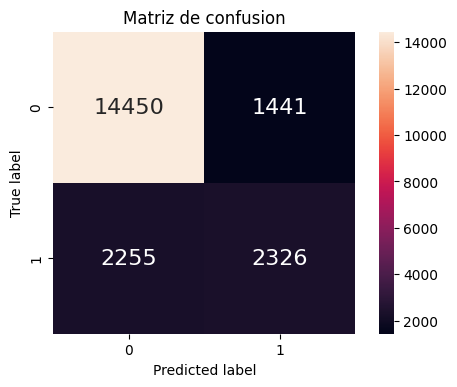

In [12]:
plot_confusion_matrix(resultados_val_dev_nb, y_pred_cont)

In [13]:
print(classification_report(resultados_val_dev_nb, y_pred_cont))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89     15891
           1       0.62      0.51      0.56      4581

    accuracy                           0.82     20472
   macro avg       0.74      0.71      0.72     20472
weighted avg       0.81      0.82      0.81     20472



In [14]:
def plot_roc(_fpr, _tpr, x):

    roc_auc = auc(_fpr, _tpr)

    plt.figure(figsize=(15, 10))
    plt.plot(
        _fpr, _tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})'
    )
    plt.scatter(_fpr, x)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

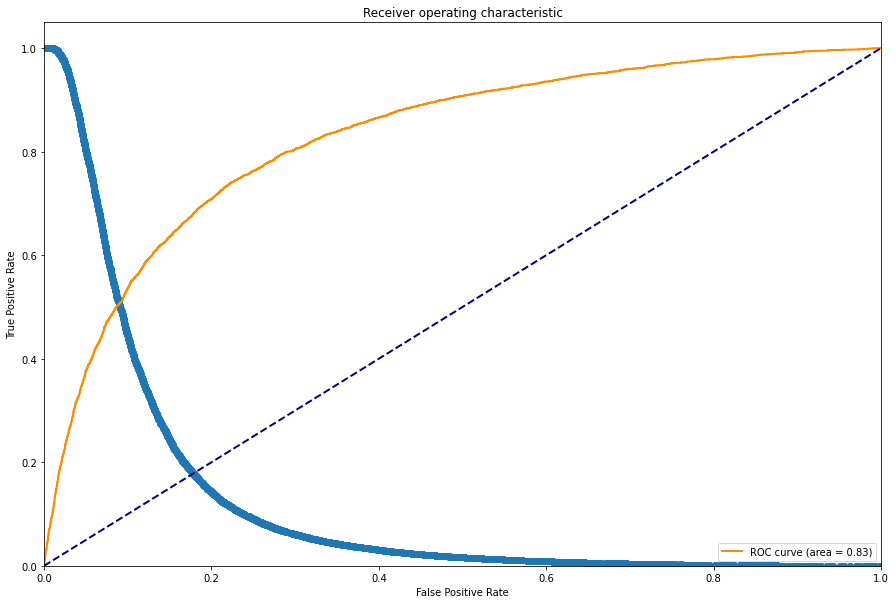

0.828086767868822

In [15]:
fpr, tpr, thresholds = roc_curve(resultados_val_dev_nb, y_pred_cont_proba)

plot_roc(fpr, tpr, thresholds)
display(roc_auc_score(resultados_val_dev_nb, y_pred_cont_proba))

## Datos Discretos

In [16]:
from preprocessing import preprocessing_discretos
datos_discretos_training, datos_discretos_val_dev = preprocessing_discretos(datos_training_nb.copy(), X_val_dev.copy())

#Parámetros discretos

In [17]:
params = {'alpha': np.logspace(0,-9, num=100),}

clf_mnb = MultinomialNB()

rgscv =  RandomizedSearchCV(
    clf_mnb, params, scoring='roc_auc', n_jobs=-1, cv=5, return_train_score=True, random_state=117
).fit(datos_discretos_training, resultados_training_nb.values.ravel())
print(f"Best score: {rgscv.best_score_}")
print(f"Best params {rgscv.best_params_}")

Best score: 0.766811332853294
Best params {'alpha': 0.8111308307896871}


In [18]:
mnb = MultinomialNB(alpha=0.8111308307896871)
kfold(mnb, datos_discretos_training.to_numpy(), resultados_training_nb.to_numpy())

fold 0: accuracy score is 0.7801
fold 1: accuracy score is 0.7821
fold 2: accuracy score is 0.7843
fold 3: accuracy score is 0.7837
fold 4: accuracy score is 0.7816
mean test accuracy is: 0.7824


#Entrenamiento y predicción val_dev discretos

In [19]:
from sklearn.model_selection import train_test_split

mnb = MultinomialNB(alpha=0.8111308307896871)
mnb_trained = mnb.fit(datos_discretos_training, resultados_training_nb.values.ravel())
y_pred_mnb = mnb_trained.predict(datos_discretos_val_dev)
y_pred_mnb_proba = mnb_trained.predict_proba(datos_discretos_val_dev)[:,1]

sum = 0
for i in range(0, len(resultados_val_dev_nb)):
  if resultados_val_dev_nb.values.ravel()[i] == y_pred_mnb[i]:
    sum += 1

print(f"Number of correct {sum} of total {len(datos_discretos_val_dev)}")
print(f"accuracy: {sum/len(datos_discretos_val_dev) * 100}%")

Number of correct 15981 of total 20472
accuracy: 78.06271981242674%


#Métricas discretos

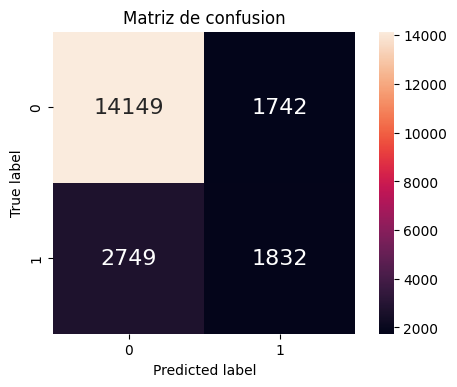

In [20]:
plot_confusion_matrix(resultados_val_dev_nb, y_pred_mnb)

In [21]:
print(classification_report(resultados_val_dev_nb, y_pred_mnb))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86     15891
           1       0.51      0.40      0.45      4581

    accuracy                           0.78     20472
   macro avg       0.67      0.65      0.66     20472
weighted avg       0.76      0.78      0.77     20472



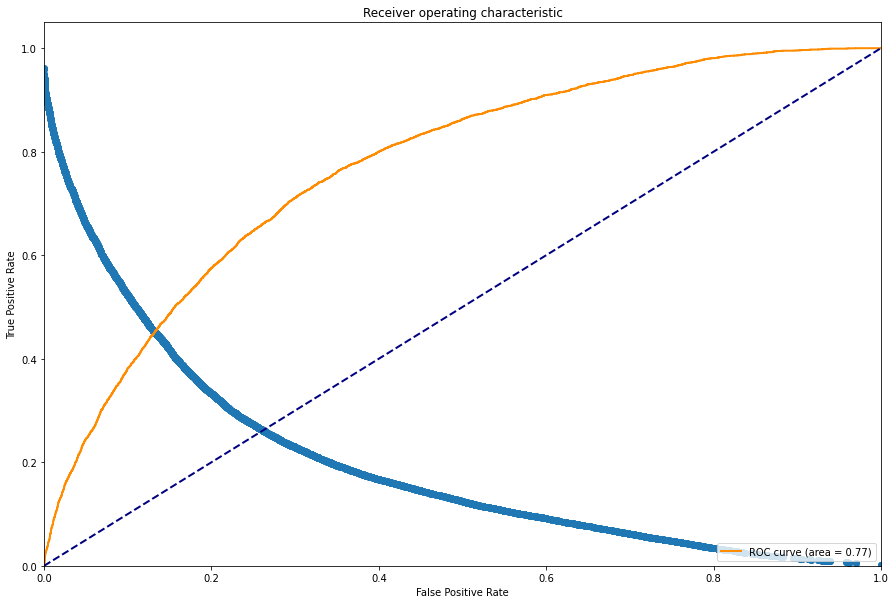

0.7713725535608628

In [22]:
fpr, tpr, thresholds = roc_curve(resultados_val_dev_nb, y_pred_mnb_proba)

plot_roc(fpr, tpr, thresholds)
display(roc_auc_score(resultados_val_dev_nb, y_pred_mnb_proba))

Comparando los dos modelos, continuo y discreto, notamos que el continuo no solo tiene mejor accuracy sino que mayor area debajo de la curva ROC (0.83 > 0.77).
Entonces elegimos al continuo como mejor modelo.

#Predicciones sobre el test-holdout

In [26]:
_datos_training_nb, datos_test = preprocessing_continuos(datos_training_nb, X_test_holdout.copy(), False)

resultados_test = y_test_holdout.copy()
resultados_test = resultados_test.reset_index()
resultados_test = resultados_test.drop(columns=['index'])
resultados_test = pd.get_dummies(resultados_test, drop_first=True, columns=['llovieron_hamburguesas_al_dia_siguiente'])

pd.DataFrame(datos_test)

,horas_de_sol,humedad_tarde,humedad_temprano,mm_evaporados_agua,mm_lluvia_dia,presion_atmosferica_tarde,presion_atmosferica_temprano,rafaga_viento_max_velocidad,temp_max,temp_min,temperatura_tarde,temperatura_temprano,velocidad_viendo_tarde,velocidad_viendo_temprano
0,7.641429,69.0,66.0,5.466639,0.0,1023.000000,1026.1,33.0,12.2,7.8,11.8,9.5,13.0,9.0
1,7.641429,31.0,64.0,5.466639,0.0,1017.400024,1020.0,31.0,21.4,3.4,19.7,11.9,13.0,7.0
2,13.800000,49.0,56.0,5.400000,0.0,1012.200012,1013.8,31.0,24.4,12.7,20.5,15.8,13.0,19.0
3,12.400000,31.0,64.0,8.600000,0.0,1011.700012,1016.5,33.0,32.5,19.0,30.5,22.1,6.0,19.0
4,9.200000,47.0,74.0,4.000000,0.0,1022.200012,1023.4,28.0,21.7,9.7,21.3,13.6,13.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11368,7.641429,32.0,74.0,5.466639,0.0,1022.799988,1025.2,31.0,24.9,8.8,24.2,14.7,19.0,11.0
11369,7.641429,94.0,79.0,5.466639,0.0,1003.000000,1007.0,69.0,14.3,8.2,13.0,12.1,19.0,19.0
11370,0.000000,64.0,65.0,4.200000,0.0,1015.799988,1016.5,24.0,21.1,12.7,20.1,16.1,7.0,6.0
11371,8.400000,58.0,91.0,2.200000,0.0,1024.000000,1026.0,24.0,20.2,9.4,18.4,13.7,11.0,0.0


In [32]:
y_pred = gnb_trained.predict(datos_test)
y_pred_proba = gnb_trained.predict_proba(datos_test)[:,1]

In [28]:
accuracy_score(y_pred, resultados_test)

0.8215070781675899

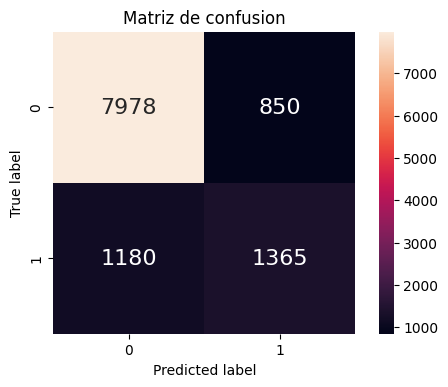

In [29]:
plot_confusion_matrix(resultados_test.to_numpy(), y_pred)

In [30]:
from sklearn.metrics import classification_report

print(classification_report(resultados_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.90      0.89      8828
           1       0.62      0.54      0.57      2545

    accuracy                           0.82     11373
   macro avg       0.74      0.72      0.73     11373
weighted avg       0.81      0.82      0.82     11373



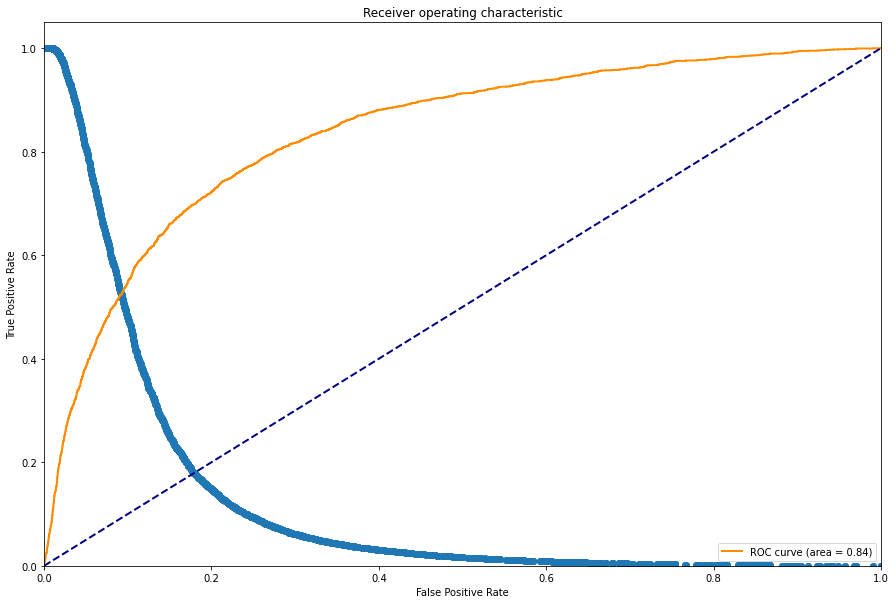

0.8352393883366286

In [33]:
fpr, tpr, thresholds = roc_curve(resultados_test.to_numpy(), y_pred_proba)

plot_roc(fpr, tpr, thresholds)
display(roc_auc_score(resultados_test.to_numpy(), y_pred_proba))

#Predicción final

In [23]:
datos_prediccion = pd.read_csv(
    'https://docs.google.com/spreadsheets/d/1mR_JNN0-ceiB5qV42Ff9hznz0HtWaoPF3B9zNGoNPY8/export?format=csv', low_memory=False
)
datos_prediccion

,barrio,dia,direccion_viento_tarde,direccion_viento_temprano,horas_de_sol,humedad_tarde,humedad_temprano,id,llovieron_hamburguesas_hoy,mm_evaporados_agua,...,presion_atmosferica_tarde,presion_atmosferica_temprano,rafaga_viento_max_direccion,rafaga_viento_max_velocidad,temp_max,temp_min,temperatura_tarde,temperatura_temprano,velocidad_viendo_tarde,velocidad_viendo_temprano
0,Villa General Mitre,2014-12-16,Oestesuroeste,Sursureste,13.4,38.0,51.0,116706,NaN,NaN,...,1010.9,1014.4,suroeste,41.0,26.8,8.9,24.9,20.6,28.0,13.0
1,Nueva Pompeya,2010-10-21,Nornoreste,Estesureste,NaN,39.0,57.0,58831,no,NaN,...,1020.2,1023.8,Norte,28.0,23.3,5.0,21.5,14.7,11.0,6.0
2,Constitución,2013-04-09,Estesureste,Oestenoroeste,3.6,73.0,90.0,31981,si,2.4,...,1024.3,1026.7,Oestenoroeste,24.0,22.0,15.6,20.7,16.7,6.0,15.0
3,Agronomía,2016-02-05,Sureste,Sureste,NaN,34.0,47.0,2533,no,NaN,...,1015.8,1018.3,Sureste,30.0,29.9,14.2,27.0,20.0,11.0,15.0
4,Balvanera,2012-06-05,suroeste,Noroeste,NaN,77.0,87.0,7270,no,2.0,...,1007.6,1006.0,suroeste,39.0,11.5,5.5,11.2,7.0,20.0,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29087,Parque Chas,2013-04-24,suroeste,Oestenoroeste,NaN,71.0,77.0,73456,no,NaN,...,1018.9,1021.2,Oeste,37.0,19.8,9.8,17.3,12.8,9.0,13.0
29088,Belgrano,2015-10-30,Norte,Noreste,NaN,37.0,64.0,14471,no,NaN,...,1017.9,1021.8,Nornoreste,41.0,29.3,15.6,27.8,20.2,15.0,28.0
29089,Villa Crespo,2011-08-09,Nornoreste,Norte,10.1,31.0,77.0,106482,no,3.2,...,1011.1,1016.3,suroeste,41.0,19.8,5.5,18.6,11.1,20.0,11.0
29090,Caballito,2017-04-25,Nornoreste,Norte,NaN,81.0,90.0,21057,no,NaN,...,1008.2,1014.6,Nornoreste,39.0,25.4,17.8,22.0,19.5,33.0,15.0


In [24]:
_datos_training_nb, X = preprocessing_continuos(datos_training_nb, datos_prediccion, False)
predicciones_nb = gnb_trained.predict(X)

predicciones_nb = pd.DataFrame(predicciones_nb).rename(columns= {0:'llovieron_hamburguesas_al_dia_siguiente'})
predicciones_nb.replace(0, 'no', inplace= True)
predicciones_nb.replace(1, 'si', inplace= True)
predicciones_nb

,llovieron_hamburguesas_al_dia_siguiente
0,no
1,no
2,no
3,no
4,si
...,...
29087,no
29088,no
29089,no
29090,si


In [25]:
predicciones_nb.to_csv("Naive_Bayes.csv")